# Linear Regression 

This notebook will construct data for regression problems (both linear and non-linear data) using scikit-learn datasets. It will then train linear regression models and regression models with non-linear pointwise activation functions on that data.


## 0. Preliminaries

In [1]:
# Import Statements

import torch
from torch import nn

from sklearn.datasets import make_regression, make_friedman1
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from helper_functions import plot_predictions, plot_loss
from models import LinearRegressionModelV0, LinearRegressionModelV1, train_step_regression, test_step_regression

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
# device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device is {device}")

# random number seed
rns=42

# Flag to make plots and print out things.
verbose = True


Device is cpu


In [3]:
def eval_model(model, 
               loss_count, 
               test_loss_count, 
               datatype,
               hid_dim,
               nl_type,
               num_layers):
    """
    Return model name, best loss and best test_loss in a dictionary to compare models at the end.
    """

    return {"model_name": model.__class__.__name__,
            "model_nonlin": nl_type,
            "model_layers": num_layers,
            "model_hidden_units": hid_dim,
            "data": datatype,
            "train_loss": np.array(loss_count).min(),
            "test_loss": np.array(test_loss_count).min()
            }

## 1. Single Layer Linear model on Linear data

### 1a. Generate Linear Data: train & test datasets

In [4]:
# linear data

dims=3
X, y, coef = make_regression(n_samples=100, n_features=dims, noise=0, bias=5, coef=True, random_state=rns)

In [5]:
print(f"X is shape: {X.shape} and type: {type(X)}")
print(f"y is shape: {y.shape} and type: {type(y)}")
print(f"Ground truth coefficients: {coef}")

X is shape: (100, 3) and type: <class 'numpy.ndarray'>
y is shape: (100,) and type: <class 'numpy.ndarray'>
Ground truth coefficients: [75.06147516 28.20345726 17.74395438]


In [6]:
# Split data into train & test sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rns)

In [7]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((80, 3), (20, 3), (80,), (20,))

In [8]:
# Convert numpy into torch tensors and put them onto device

X_train = torch.from_numpy(X_train).type(torch.float32).to(device)
y_train = torch.from_numpy(y_train).type(torch.float32).to(device)
X_test = torch.from_numpy(X_test).type(torch.float32).to(device)
y_test = torch.from_numpy(y_test).type(torch.float32).to(device)

In [9]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([80, 3]), torch.Size([20, 3]), torch.Size([80]), torch.Size([20]))

In [10]:
# Make y_train & y_test dimensions to be same as what model will predict - ie model0(X).

y_train = y_train.unsqueeze(dim=1)
y_test = y_test.unsqueeze(dim=1)

In [11]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([80, 3]),
 torch.Size([20, 3]),
 torch.Size([80, 1]),
 torch.Size([20, 1]))

### 1b. Visualize data

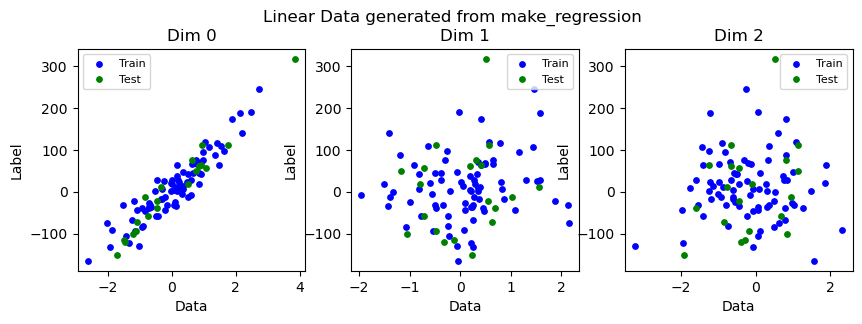

In [12]:
# Visualize data 

if verbose:
    fig = plt.figure(figsize=(10,3))
    for dim in range(dims):

        plt.subplot(1, dims, dim+1)
        plot_predictions(train_data = X_train[:,dim],
                        train_labels = y_train,
                        test_data = X_test[:,dim],
                        test_labels = y_test
                        )
        fig.subplots_adjust(top=0.85)
        plt.title(f'Dim {dim}')
    fig.suptitle('Linear Data generated from make_regression')

### 1c. Build and instantiate linear regression model

In [13]:
# LinearRegressionModelV0 defined in models.py
#
# LinearRegressionModelV0 is a single linear layer with 'in_dim' weights and 1 bias parameter 
# to fit a line in 'in_dim' dimensions. Should work for linear regression and fail when data becomes
# more non-linear.

# instantiate model
hid_dim=None
nl_type=None

model0 = LinearRegressionModelV0(in_dim=dims).to(device) # single linear layer with 'dims' weight terms & 1 bias term.

In [14]:
print(f"Randomly initialized, model0 looks like: \n {model0.state_dict()}")

Randomly initialized, model0 looks like: 
 OrderedDict([('linear_layer1.weight', tensor([[ 0.0497, -0.0301,  0.1842]])), ('linear_layer1.bias', tensor([0.4006]))])


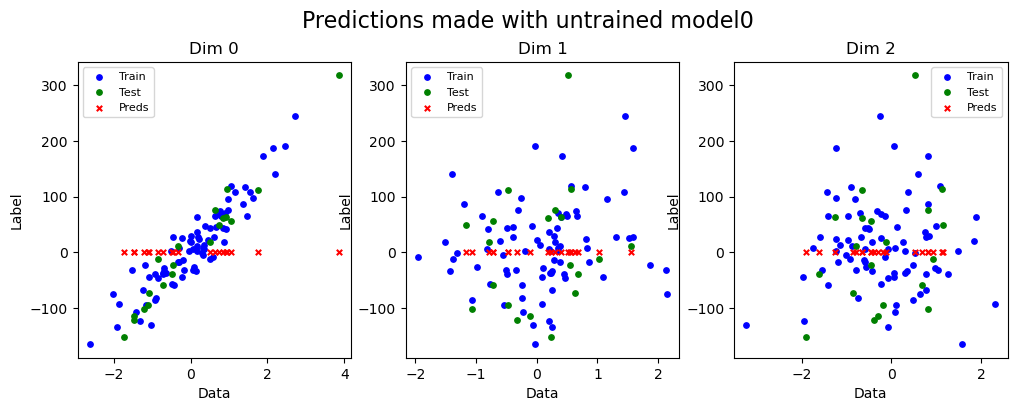

In [15]:
# Make predictions with untrained model and visualize
if verbose:
    with torch.inference_mode():
        preds = model0(X_test)

    fig = plt.figure(figsize=(12,4))
    for dim in range(dims):
        plt.subplot(1, dims, dim+1)
        plot_predictions(train_data = X_train[:,dim],
                        train_labels = y_train,
                        test_data = X_test[:,dim],
                        test_labels = y_test,
                        predictions = preds
                        )
        fig.subplots_adjust(top=0.85)
        plt.title(f"Dim {dim}")
    fig.suptitle("Predictions made with untrained model0",fontsize=16);

### 1d. Train linear model on linear data

In [16]:
# Setup loss function and optimizer

# For linear regression problems, can use mean squared error (MSELoss) or mean absolute error (L1Loss)
loss_fn = nn.L1Loss() 
# loss_fn = nn.MSELoss() 

# Set optimizer to be Stochastic Gradient Descent and pass in model parameters.
optimizer = torch.optim.SGD(params = model0.parameters(),
                            lr = 0.1)

In [17]:
# Setup lists to gather loss through training
epoch_count = []
loss_count = []
test_loss_count = []

epochs = 3000 # how many times to run training loop - run through all data and adjust model params.
test_freq = 100 # how often to run test step and print out, collect up results to track progress

# 1. Loop through all data
for epoch in range(epochs):

    # 2. Training step
    loss = train_step_regression(data = X_train,
                                 labels = y_train,
                                 model = model0,
                                 loss_fn = loss_fn,
                                 optimizer = optimizer)
    
    # 3. print what's happening at test_freq
    if epoch % test_freq == 0:
        
        # 4. Test step
        test_loss = test_step_regression(data = X_test,
                                         labels = y_test,
                                         model = model0,
                                         loss_fn = loss_fn) 
        
        # Collect performance into lists
        epoch_count.append(epoch)
        loss_count.append(loss.item())
        test_loss_count.append(test_loss.item())
        
        # Print performance
        print(f"Epoch: {epoch:5d} | loss: {loss:.6f} | test loss: {test_loss:.6f}")

Epoch:     0 | loss: 57.969116 | test loss: 83.221397
Epoch:   100 | loss: 52.426991 | test loss: 75.451645
Epoch:   200 | loss: 46.984837 | test loss: 67.684875
Epoch:   300 | loss: 41.757439 | test loss: 59.999714
Epoch:   400 | loss: 36.662395 | test loss: 52.646320
Epoch:   500 | loss: 31.940302 | test loss: 45.805916
Epoch:   600 | loss: 27.397959 | test loss: 39.179230
Epoch:   700 | loss: 22.856018 | test loss: 32.552940
Epoch:   800 | loss: 18.352253 | test loss: 25.945858
Epoch:   900 | loss: 13.920057 | test loss: 19.456812
Epoch:  1000 | loss: 9.725779 | test loss: 13.468697
Epoch:  1100 | loss: 5.663061 | test loss: 7.838167
Epoch:  1200 | loss: 1.645289 | test loss: 2.245245
Epoch:  1300 | loss: 0.078492 | test loss: 0.026736
Epoch:  1400 | loss: 0.078492 | test loss: 0.026736
Epoch:  1500 | loss: 0.078492 | test loss: 0.026736
Epoch:  1600 | loss: 0.078492 | test loss: 0.026736
Epoch:  1700 | loss: 0.078492 | test loss: 0.026736
Epoch:  1800 | loss: 0.078492 | test loss: 

### 1e. Visualize results: Linear regression model predicting on linear data

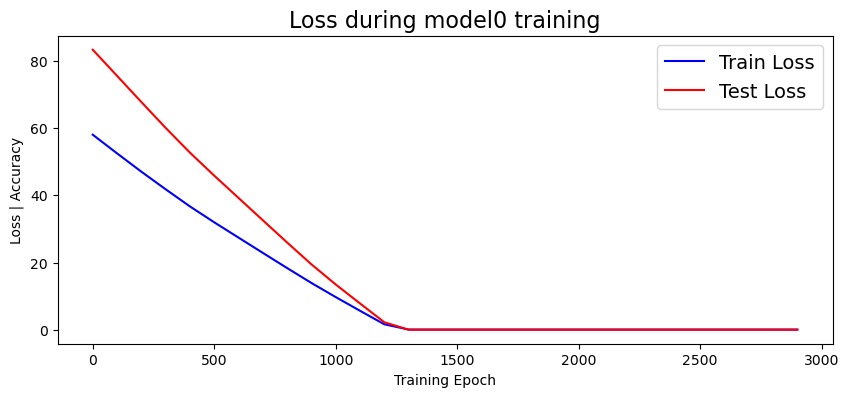

In [18]:
# Plot the loss
if verbose:
    plt.figure(figsize=(10,4))
    plot_loss(epoch = epoch_count,
             loss = loss_count,
             test_loss = test_loss_count,
             y_scale='linear')
    plt.title("Loss during model0 training",fontsize=16);

Model 0 = 
 LinearRegressionModelV0(
  (linear_layer1): Linear(in_features=3, out_features=1, bias=True)
)


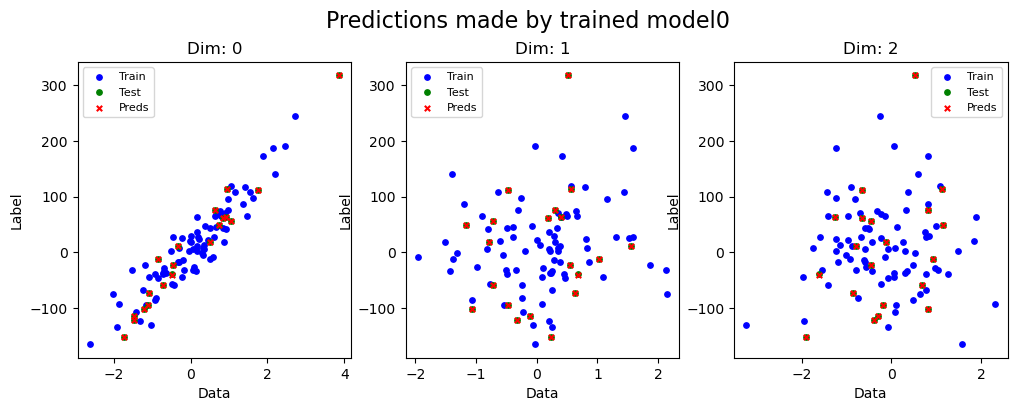

In [19]:
# Make predictions with trained model and visualize

if verbose:
    with torch.inference_mode():
        preds = model0(X_test)

    fig = plt.figure(figsize=(12,4))
    for dim in range(dims):
        plt.subplot(1, dims, dim+1)
        plot_predictions(train_data = X_train[:,dim],
                        train_labels = y_train,
                        test_data = X_test[:,dim],
                        test_labels = y_test,
                        predictions = preds
                        )
        fig.subplots_adjust(top=0.85)
        plt.title(f"Dim: {dim}")
    fig.suptitle('Predictions made by trained model0',fontsize=16)
    print(f"Model 0 = \n {model0}")

In [20]:
print(f"Model after training: {model0.state_dict()}")

Model after training: OrderedDict([('linear_layer1.weight', tensor([[75.0587, 28.1869, 17.7626]])), ('linear_layer1.bias', tensor([4.9269]))])


In [21]:
print(f"Ground truth coefficients were: {coef}")

Ground truth coefficients were: [75.06147516 28.20345726 17.74395438]


In [22]:
model0

LinearRegressionModelV0(
  (linear_layer1): Linear(in_features=3, out_features=1, bias=True)
)

In [23]:
results0 = eval_model(model=model0,
                      loss_count=loss_count,
                      test_loss_count=test_loss_count,
                      datatype="linear",
                      hid_dim=hid_dim,
                      nl_type=nl_type,
                      num_layers=1)

**Conclusion**: Our single layer Linear Regression model, model0, does well predicting linear data. Model predictions, red x, above lie right on top of ground truth, green o, for test data - data that model never saw during training. Also, the weights learned by the model match very closely the ground truth coefficients used to train the model. **But, how will it do on non-linear data?**

## 2. Single Layer Linear Model on Non-linear data

### 2a. Generate Nonlinear data

In [24]:
# Generate nonlinear data - from Scikit Learn's Friedman1 generator.
#
# y(X) = 10 * sin(pi * X[:, 0] * X[:, 1]) +
#        20 * (X[:, 2] - 0.5) ** 2 + 
#        10 * X[:, 3] + 5 * X[:, 4] + 
#        noise * N(0, 1).
#
# Note: Only the 1st 5 dimensions contribute to the nonlinear signal. Dimensions beyond 5 do not contribute to y.

dims=5
Xnl, ynl = make_friedman1(n_samples=500, n_features=dims, noise=0, random_state=rns)

In [25]:
print(f"X is shape: {Xnl.shape} and type: {type(Xnl)}")
print(f"y is shape: {ynl.shape} and type: {type(ynl)}")

X is shape: (500, 5) and type: <class 'numpy.ndarray'>
y is shape: (500,) and type: <class 'numpy.ndarray'>


In [26]:
# Split data into train & test sets

Xnl_train, Xnl_test, ynl_train, ynl_test = train_test_split(Xnl, ynl, test_size=0.2, random_state=rns)

In [27]:
# Convert numpy into torch tensors and put them onto device

Xnl_train = torch.from_numpy(Xnl_train).type(torch.float32).to(device)
ynl_train = torch.from_numpy(ynl_train).type(torch.float32).to(device)
Xnl_test = torch.from_numpy(Xnl_test).type(torch.float32).to(device)
ynl_test = torch.from_numpy(ynl_test).type(torch.float32).to(device)

In [28]:
Xnl_train.shape, Xnl_test.shape, ynl_train.shape, ynl_test.shape

(torch.Size([400, 5]),
 torch.Size([100, 5]),
 torch.Size([400]),
 torch.Size([100]))

In [29]:
# Make ynl_train & ynl_test dimensions to be same as what model will predict - ie model(X).

ynl_train = ynl_train.unsqueeze(dim=1)
ynl_test = ynl_test.unsqueeze(dim=1)

In [30]:
Xnl_train.shape, Xnl_test.shape, ynl_train.shape, ynl_test.shape

(torch.Size([400, 5]),
 torch.Size([100, 5]),
 torch.Size([400, 1]),
 torch.Size([100, 1]))

### 2b. Visualize nonlinear data

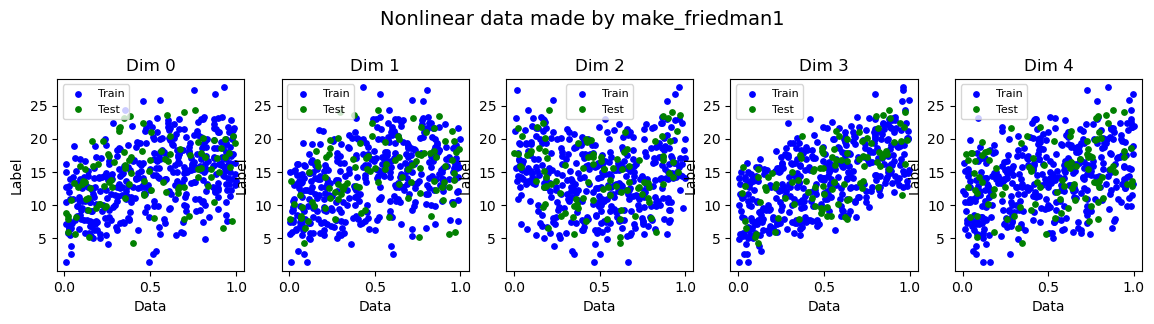

In [31]:
# Visualize data 

if verbose:
    fig = plt.figure(figsize=(14,3))
    rows=1
    for dim in range(dims):
        plt.subplot(rows,int(np.ceil(dims/rows)),dim+1)
        plot_predictions(train_data = Xnl_train[:,dim],
                        train_labels = ynl_train,
                        test_data = Xnl_test[:,dim],
                        test_labels = ynl_test
                        )
        fig.subplots_adjust(top=0.75)
        plt.title(f"Dim {dim}")
    fig.suptitle('Nonlinear data made by make_friedman1',fontsize=14)

### 2c. Build and instantiate linear model

In [32]:
# LinearRegressionModelV0 defined in models.py
#
# LinearRegressionModelV0 is a single linear layer with 'in_dim' weights and 1 bias parameter 
# to fit a line in 'in_dim' dimensions. Should work for linear regression and fail when data becomes
# more non-linear.

# instantiate model
hid_dim=None
nl_type=None

model1 = LinearRegressionModelV0(in_dim=dims).to(device) # single linear layer with 'dims' weight terms & 1 bias term.

In [33]:
print(f"Randomly initialized, model1 looks like: \n {model1.state_dict()}")

Randomly initialized, model1 looks like: 
 OrderedDict([('linear_layer1.weight', tensor([[-0.1748, -0.1559,  0.4231, -0.2194, -0.2424]])), ('linear_layer1.bias', tensor([-0.4201]))])


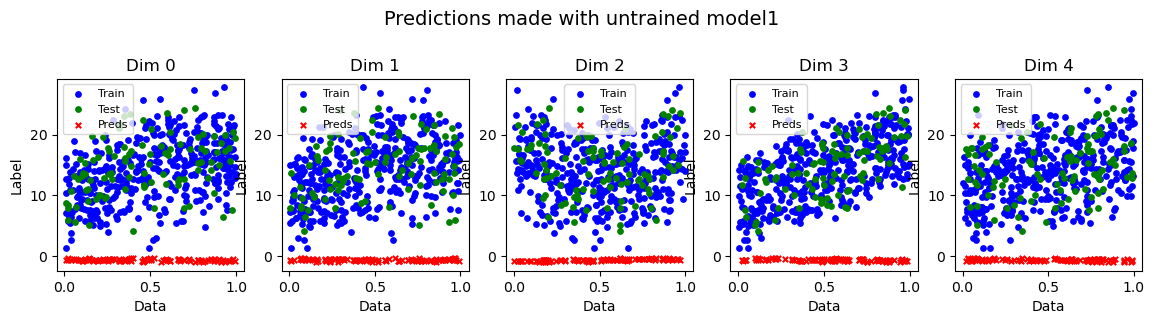

In [34]:
# Make predictions with untrained model and visualize
with torch.inference_mode():
    preds = model1(Xnl_test)
    
fig = plt.figure(figsize=(14,3))
rows=1
for dim in range(dims):
    plt.subplot(1, int(np.ceil(dims/1)), dim+1)
    plot_predictions(train_data = Xnl_train[:,dim],
                    train_labels = ynl_train,
                    test_data = Xnl_test[:,dim],
                    test_labels = ynl_test,
                    predictions = preds
                    )
    fig.subplots_adjust(top=0.75)
    plt.title(f"Dim {dim}")
fig.suptitle('Predictions made with untrained model1',fontsize=14);

### 1d. Train a single layer linear model on nonlinear data

In [35]:
# Setup loss function and optimizer

# loss_fn = nn.L1Loss() 
loss_fn = nn.MSELoss() 

optimizer = torch.optim.SGD(params = model1.parameters(),
                            lr = 0.01)

In [36]:
# Train the model

# Setup lists to gather loss through training
epoch_count = []
loss_count = []
test_loss_count = []

epochs = 3000
test_freq = 300

# 1. Loop through all data
for epoch in range(epochs):

    # 2. Training step
    loss = train_step_regression(data = Xnl_train,
                                 labels = ynl_train,
                                 model = model1,
                                 loss_fn = loss_fn,
                                 optimizer = optimizer)
    
    # 3. print what's happening at test_freq
    if epoch % test_freq == 0:
        
        # 4. Test step
        test_loss = test_step_regression(data = Xnl_test,
                                         labels = ynl_test,
                                         model = model1,
                                         loss_fn = loss_fn) 
        
        # Collect performance into lists
        epoch_count.append(epoch)
        loss_count.append(loss.item())
        test_loss_count.append(test_loss.item())
        
        # Print performance
        print(f"Epoch: {epoch:5d} | loss: {loss:.6f} | test loss: {test_loss:.6f}")

Epoch:     0 | loss: 242.593475 | test loss: 236.026321
Epoch:   300 | loss: 8.959084 | test loss: 9.265406
Epoch:   600 | loss: 7.091544 | test loss: 7.572813
Epoch:   900 | loss: 6.300570 | test loss: 6.786456
Epoch:  1200 | loss: 5.942520 | test loss: 6.386770
Epoch:  1500 | loss: 5.769043 | test loss: 6.166405
Epoch:  1800 | loss: 5.679625 | test loss: 6.036713
Epoch:  2100 | loss: 5.631139 | test loss: 5.956600
Epoch:  2400 | loss: 5.603829 | test loss: 5.905350
Epoch:  2700 | loss: 5.588032 | test loss: 5.871710


### 2e. Visualize results: Linear regression model predicting on nonlinear data

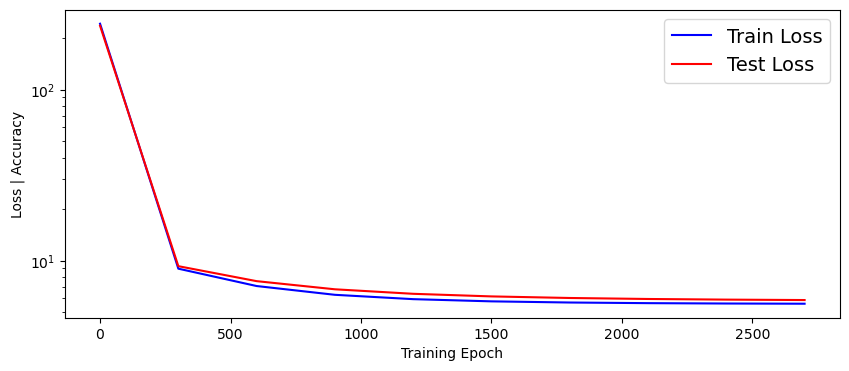

In [37]:
# Plot the loss
if verbose:
    plt.figure(figsize=(10,4))
    plot_loss(epoch = epoch_count,
             loss = loss_count,
             test_loss = test_loss_count,
             y_scale='log')

Model 1 = 
 LinearRegressionModelV0(
  (linear_layer1): Linear(in_features=5, out_features=1, bias=True)
)


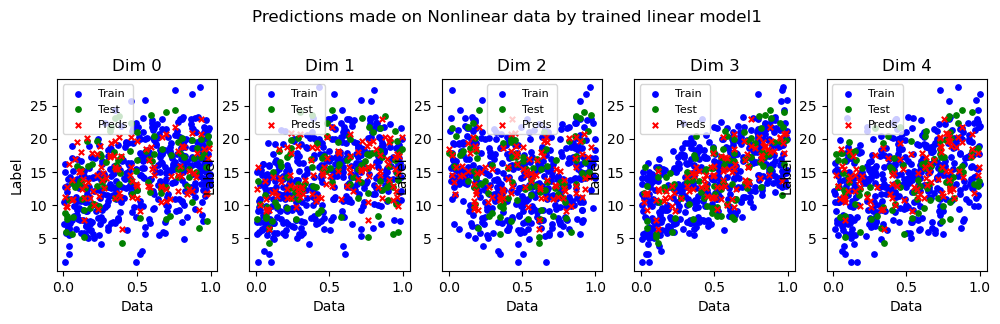

In [38]:
# Make predictions with trained model and visualize
if verbose:
    with torch.inference_mode():
        preds = model1(Xnl_test)
        
    fig=plt.figure(figsize=(12,3))
    rows=1
    for dim in range(dims):
        plt.subplot(rows,int(np.ceil(dims/rows)),dim+1)
        plot_predictions(train_data = Xnl_train[:,dim],
                        train_labels = ynl_train,
                        test_data = Xnl_test[:,dim],
                        test_labels = ynl_test,
                        predictions = preds
                        )
        fig.subplots_adjust(top=0.75)
        plt.title(f"Dim {dim}")
    fig.suptitle("Predictions made on Nonlinear data by trained linear model1")
    print(f"Model 1 = \n {model1}")

In [39]:
results1 = eval_model(model=model1,
                      loss_count=loss_count,
                      test_loss_count=test_loss_count,
                      datatype="nonlinear",
                      hid_dim=hid_dim,
                      nl_type=nl_type,
                      num_layers=1)

**Conclusion:** Single layer linear model Model does learn on non-linear data but loss bottoms out and we can see predictions (red xs) dont match ground truth (green os) that well.

## 3. Three Layer Linear Model on non-linear data

Using the same non-linear data from make_freidman1, we will train a 3 layer linear model on it to see if that does better.

In [40]:
# models built / defined in models.py

# instantiate model
hid_dim=10
nl_type=None

model2 = LinearRegressionModelV1(in_dim=dims,
                                 hid_dim=hid_dim,
                                 nl_type=nl_type).to(device) 


In [41]:
model2

LinearRegressionModelV1(
  (linear_layer1): Linear(in_features=5, out_features=10, bias=True)
  (linear_layer2): Linear(in_features=10, out_features=10, bias=True)
  (linear_layer3): Linear(in_features=10, out_features=1, bias=True)
  (nl): Identity()
)

In [42]:
# print(f"Randomly initialized, model2 looks like: \n {model2.state_dict()}")

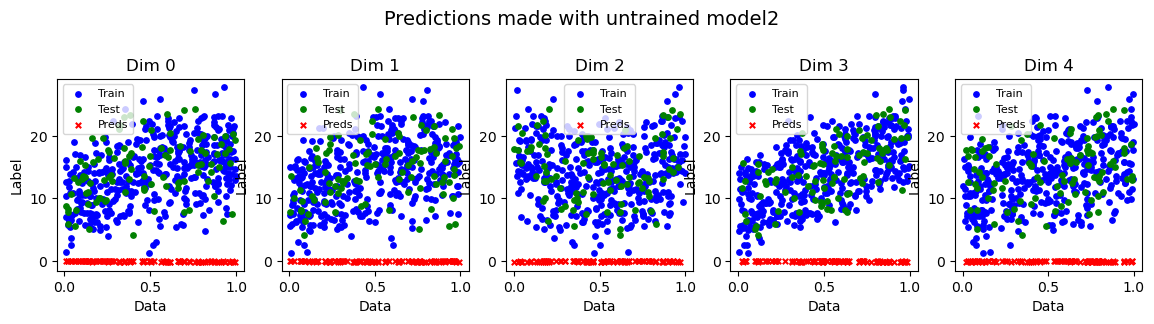

In [43]:
# Make predictions with untrained model and visualize

with torch.inference_mode():
    preds = model2(Xnl_test)
    
fig = plt.figure(figsize=(14,3))
rows=1
for dim in range(dims):
    plt.subplot(1, int(np.ceil(dims/1)), dim+1)
    plot_predictions(train_data = Xnl_train[:,dim],
                    train_labels = ynl_train,
                    test_data = Xnl_test[:,dim],
                    test_labels = ynl_test,
                    predictions = preds
                    )
    fig.subplots_adjust(top=0.75)
    plt.title(f"Dim {dim}")
fig.suptitle('Predictions made with untrained model2',fontsize=14);

In [44]:
# Setup loss function and optimizer

# loss_fn = nn.L1Loss() 
loss_fn = nn.MSELoss() 

optimizer = torch.optim.SGD(params = model2.parameters(),
                            lr = 0.01)

In [45]:
# Train the model

# Setup lists to gather loss through training
epoch_count = []
loss_count = []
test_loss_count = []

epochs = 3000
test_freq = 300

# 1. Loop through all data
for epoch in range(epochs):

    # 2. Training step
    loss = train_step_regression(data = Xnl_train,
                                 labels = ynl_train,
                                 model = model2,
                                 loss_fn = loss_fn,
                                 optimizer = optimizer)
    
    # 3. print what's happening at test_freq
    if epoch % test_freq == 0:
        
        # 4. Test step
        test_loss = test_step_regression(data = Xnl_test,
                                         labels = ynl_test,
                                         model = model2,
                                         loss_fn = loss_fn) 
        
        # Collect performance into lists
        epoch_count.append(epoch)
        loss_count.append(loss.item())
        test_loss_count.append(test_loss.item())
        
        # Print performance
        print(f"Epoch: {epoch:5d} | loss: {loss:.6f} | test loss: {test_loss:.6f}")

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Epoch:     0 | loss: 226.271667 | test loss: 215.063293
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) 

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Epoch:   900 | loss: 5.565009 | test loss: 5.792443
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Adva

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


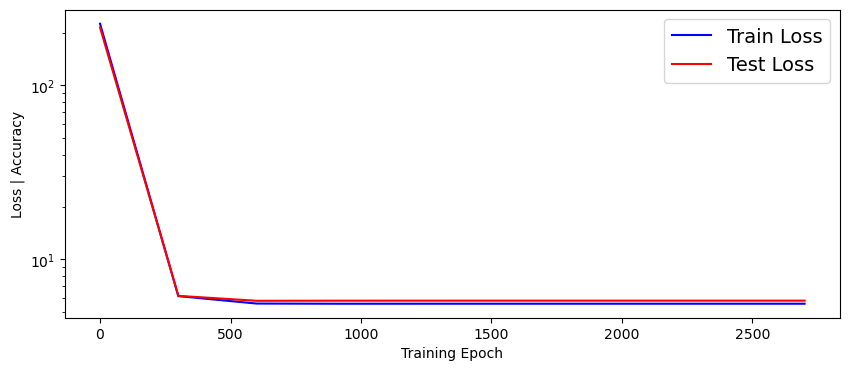

In [46]:
# Plot the loss

if verbose:
    plt.figure(figsize=(10,4))
    plot_loss(epoch = epoch_count,
             loss = loss_count,
             test_loss = test_loss_count,
             y_scale='log')

Model 2 = 
 LinearRegressionModelV1(
  (linear_layer1): Linear(in_features=5, out_features=10, bias=True)
  (linear_layer2): Linear(in_features=10, out_features=10, bias=True)
  (linear_layer3): Linear(in_features=10, out_features=1, bias=True)
  (nl): Identity()
)


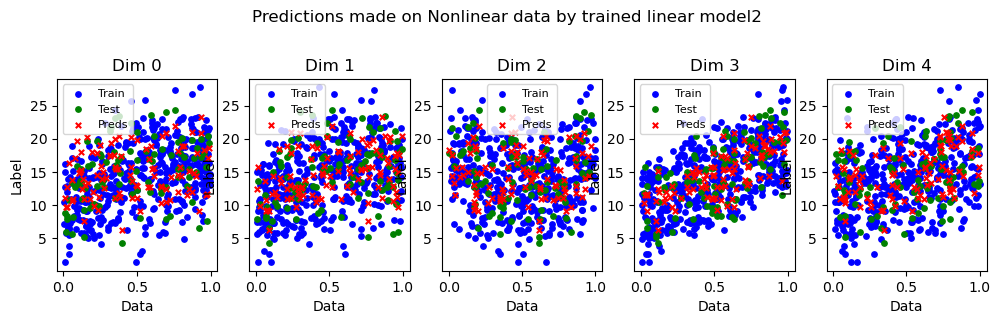

In [47]:
# Make predictions with trained model and visualize

if verbose:
    with torch.inference_mode():
        preds = model2(Xnl_test)
        
    fig=plt.figure(figsize=(12,3))
    rows=1
    for dim in range(dims):
        plt.subplot(rows,int(np.ceil(dims/rows)),dim+1)
        plot_predictions(train_data = Xnl_train[:,dim],
                        train_labels = ynl_train,
                        test_data = Xnl_test[:,dim],
                        test_labels = ynl_test,
                        predictions = preds
                        )
        fig.subplots_adjust(top=0.75)
        plt.title(f"Dim {dim}")
    fig.suptitle("Predictions made on Nonlinear data by trained linear model2")
    print(f"Model 2 = \n {model2}")

In [48]:
results2 = eval_model(model=model2,
                      loss_count=loss_count,
                      test_loss_count=test_loss_count,
                      datatype="nonlinear",
                      hid_dim=hid_dim,
                      nl_type=nl_type,
                      num_layers=3)

**Conclusion:** Three layer linear model does learn on non-linear data but loss bottoms out at basically where the single layer linear did. And the predictions it makes (red x's) dont match ground truth (green o's) any better.



## 4. Three Layer Non-linear Model on non-linear data

In [49]:
# models built / defined in models.py

# instantiate model
hid_dim=10
nl_type='relu'

model3 = LinearRegressionModelV1(in_dim=dims,
                                 hid_dim=hid_dim,
                                 nl_type=nl_type).to(device) 

In [50]:
model3

LinearRegressionModelV1(
  (linear_layer1): Linear(in_features=5, out_features=10, bias=True)
  (linear_layer2): Linear(in_features=10, out_features=10, bias=True)
  (linear_layer3): Linear(in_features=10, out_features=1, bias=True)
  (nl): ReLU()
)

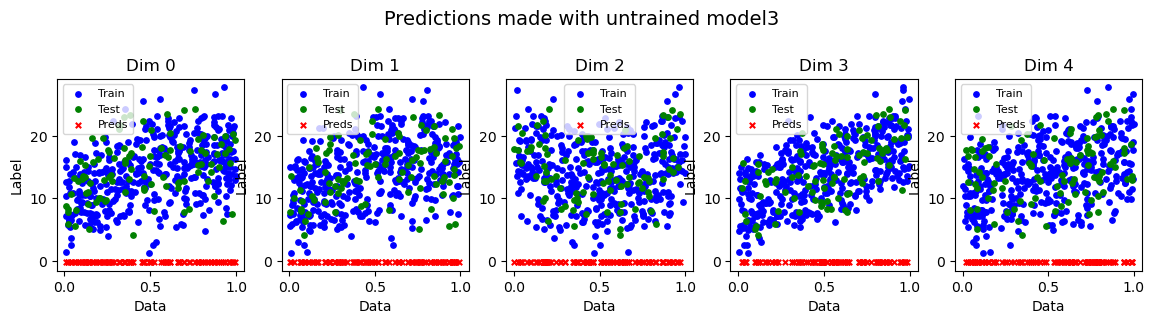

In [51]:
# Make predictions with untrained model and visualize

with torch.inference_mode():
    preds = model3(Xnl_test)
    
fig = plt.figure(figsize=(14,3))
rows=1
for dim in range(dims):
    plt.subplot(1, int(np.ceil(dims/1)), dim+1)
    plot_predictions(train_data = Xnl_train[:,dim],
                    train_labels = ynl_train,
                    test_data = Xnl_test[:,dim],
                    test_labels = ynl_test,
                    predictions = preds
                    )
    fig.subplots_adjust(top=0.75)
    plt.title(f"Dim {dim}")
fig.suptitle('Predictions made with untrained model3',fontsize=14);

In [52]:
# Setup loss function and optimizer

# loss_fn = nn.L1Loss() 
loss_fn = nn.MSELoss() 

optimizer = torch.optim.SGD(params = model3.parameters(),
                            lr = 0.01)

In [53]:
# Train the model

# Setup lists to gather loss through training
epoch_count = []
loss_count = []
test_loss_count = []

epochs = 10000
test_freq = 300

# 1. Loop through all data
for epoch in range(epochs):

    # 2. Training step
    loss = train_step_regression(data = Xnl_train,
                                 labels = ynl_train,
                                 model = model3,
                                 loss_fn = loss_fn,
                                 optimizer = optimizer)
    
    # 3. print what's happening at test_freq
    if epoch % test_freq == 0:
        
        # 4. Test step
        test_loss = test_step_regression(data = Xnl_test,
                                         labels = ynl_test,
                                         model = model3,
                                         loss_fn = loss_fn) 
        
        # Collect performance into lists
        epoch_count.append(epoch)
        loss_count.append(loss.item())
        test_loss_count.append(test_loss.item())
        
        # Print performance
        print(f"Epoch: {epoch:5d} | loss: {loss:.6f} | test loss: {test_loss:.6f}")

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Epoch:     0 | loss: 227.895004 | test loss: 230.348083
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) 

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


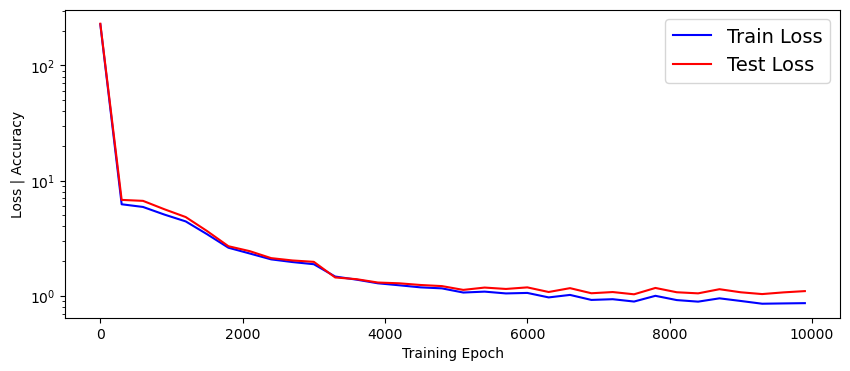

In [54]:
# Plot the loss

if verbose:
    plt.figure(figsize=(10,4))
    plot_loss(epoch = epoch_count,
             loss = loss_count,
             test_loss = test_loss_count,
             y_scale='log')

Model 3 = 
 LinearRegressionModelV1(
  (linear_layer1): Linear(in_features=5, out_features=10, bias=True)
  (linear_layer2): Linear(in_features=10, out_features=10, bias=True)
  (linear_layer3): Linear(in_features=10, out_features=1, bias=True)
  (nl): ReLU()
)


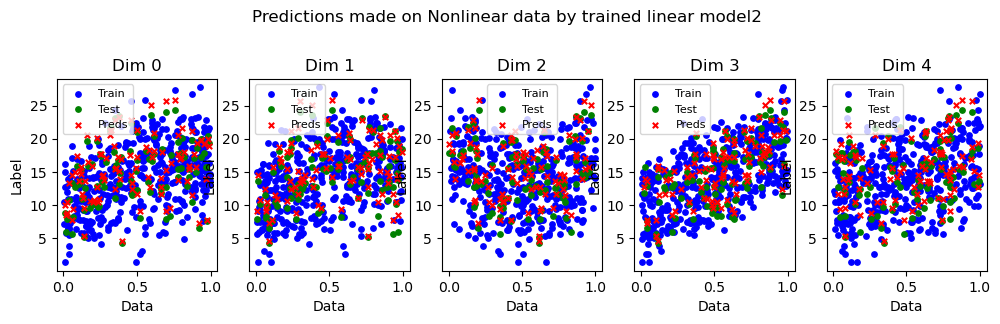

In [55]:
# Make predictions with trained model and visualize

if verbose:
    with torch.inference_mode():
        preds = model3(Xnl_test)
        
    fig=plt.figure(figsize=(12,3))
    rows=1
    for dim in range(dims):
        plt.subplot(rows,int(np.ceil(dims/rows)),dim+1)
        plot_predictions(train_data = Xnl_train[:,dim],
                        train_labels = ynl_train,
                        test_data = Xnl_test[:,dim],
                        test_labels = ynl_test,
                        predictions = preds
                        )
        fig.subplots_adjust(top=0.75)
        plt.title(f"Dim {dim}")
    fig.suptitle("Predictions made on Nonlinear data by trained linear model2")
    print(f"Model 3 = \n {model3}")

In [56]:
results3 = eval_model(model=model3,
                      loss_count=loss_count,
                      test_loss_count=test_loss_count,
                      datatype="nonlinear",
                      hid_dim=hid_dim,
                      nl_type=nl_type,
                      num_layers=3)

**Conclusion:** Three layer non-linear model does learn on non-linear data better than linear models. And the predictions it makes (red x's) are closer to ground truth (green o's). Still not perfect, but we can train for longer. We can also add more hidden units.

In [57]:
res = pd.DataFrame([results0,results1,results2,results3])
res.head()

model_name model_nonlin  model_layers  model_hidden_units  \
0  LinearRegressionModelV0         None             1                 NaN   
1  LinearRegressionModelV0         None             1                 NaN   
2  LinearRegressionModelV1         None             3                10.0   
3  LinearRegressionModelV1         relu             3                10.0   

        data  model_loss  model_acc  
0     linear    0.078492   0.026736  
1  nonlinear    5.588032   5.871710  
2  nonlinear    5.564757   5.785002  
3  nonlinear    0.853807   1.030857